In [20]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy.signal import find_peaks
import SpectralEvents.spectralevents as se
%matplotlib inline

In [4]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

In [5]:
# import behavior projet cache class from SDK to be able to load the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)

# if we needed to download the data we could have used the following line
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_root)  

In [6]:
# get the metadata tables
# units_table = cache.get_unit_table()

channels_table = cache.get_channel_table()

behavior_sessions_table = cache.get_behavior_session_table()

ecephys_sessions_table = cache.get_ecephys_session_table()

probes = cache.get_probe_table()
valid_lfp = probes[probes['has_lfp_data']]

print('Fraction of insertions with valid LFP: ', len(valid_lfp)/len(probes))

Fraction of insertions with valid LFP:  0.9602209944751381


In [7]:
session_id = probes.loc[1064735073]['ecephys_session_id']
session = cache.get_ecephys_session(
            ecephys_session_id=session_id)
running_speed = session.running_speed

/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [8]:
lfp = session.get_lfp(1064735073)

/opt/conda/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [9]:
stim_presentations = session.stimulus_presentations
flashes = stim_presentations[stim_presentations['stimulus_name'].str.contains('flash')]
spontaneous = stim_presentations[stim_presentations['stimulus_name'].str.contains('spont')]
presentation_times = flashes.start_time.values
presentation_ids = flashes.index.values

spontaneous_times  = (spontaneous.start_time.values[1], spontaneous.end_time.values[1])
rest_times = running_speed.timestamps[running_speed.speed < 10]



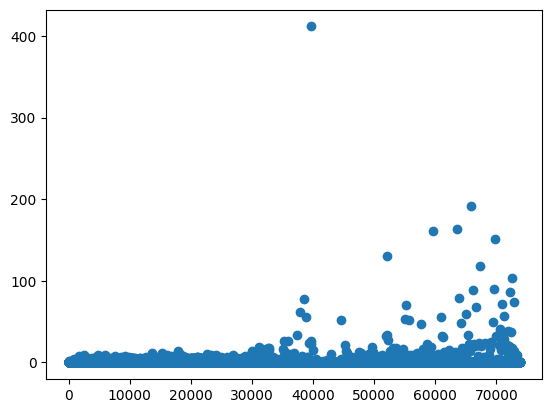

In [10]:
plt.scatter(range(len(rest_times) -1), np.diff(rest_times.values))

In [89]:
def align_lfp(lfp, trial_window, alignment_times, trial_ids = None):
    '''
    Aligns the LFP data array to experiment times of interest
    INPUTS:
        lfp: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([trial_window + t for t in alignment_times])
    
    if trial_ids is None:
        trial_ids = np.arange(len(alignment_times))
        
    inds = pd.MultiIndex.from_product((trial_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))

    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
    ds = ds.assign(time=inds).unstack('time')

    return ds['aligned_lfp']

def align_running(running_speed, trial_window, alignment_times, trial_ids = None):
    '''
    Aligns the running data array to experiment times of interest
    INPUTS:
        running_speed: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([trial_window + t for t in alignment_times])
    
    if trial_ids is None:
        trial_ids = np.arange(len(alignment_times))
        
    inds = pd.MultiIndex.from_product((trial_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))

    ds = running_speed.sel(timestamps = time_selection, method='nearest')
    ds = ds.assign(timestamps=inds).unstack('timestamps')

    return ds.speed.values


def window_lfp(lfp, alignment_window, trial_ids = None):
    '''
    Aligns the LFP data array to experiment times of interest
    INPUTS:
        lfp: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([alignment_window])
    
    if trial_ids is None:
        trial_ids = [1]
        
    # inds = pd.MultiIndex.from_product((trial_ids, alignment_window), 
    #                                   names=('presentation_id', 'time_from_presentation_onset'))

    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')

    return ds['aligned_lfp']

In [90]:
aligned_lfp = align_lfp(lfp, np.arange(-0.5, 0.5, 1/500), presentation_times, presentation_ids)
aligned_running = align_running(running_speed.set_index('timestamps').to_xarray(), np.arange(-0.5, 0.5, 1/60), presentation_times, presentation_ids)

spont_window = np.arange(spontaneous_times[0], spontaneous_times[1], 1/500)
spont_lfp = window_lfp(lfp, spont_window).squeeze().T



In [92]:
chans = session.get_channels()
lfp_chan_depths = [chans.loc[c]['probe_vertical_position'] for c in lfp.channel.values]

chans_in_brain = chans[(chans['probe_id']==1064735073)&(~chans['structure_acronym'].str.contains('root'))]
first_channel_in_brain_position = chans_in_brain['probe_vertical_position'].max()

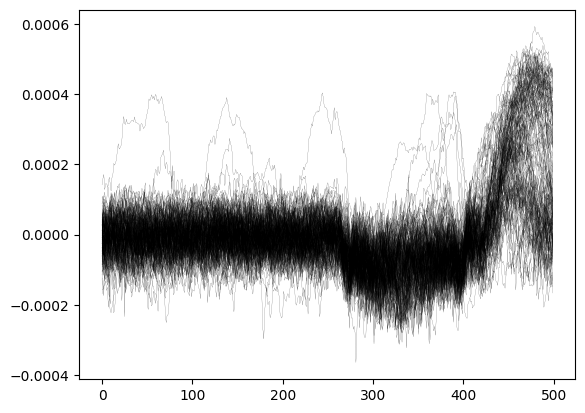

In [93]:
_ = plt.plot(aligned_lfp[76,:,:].T, color='k', linewidth=0.1)

Text(-0.4, 3570, 'brain surface')

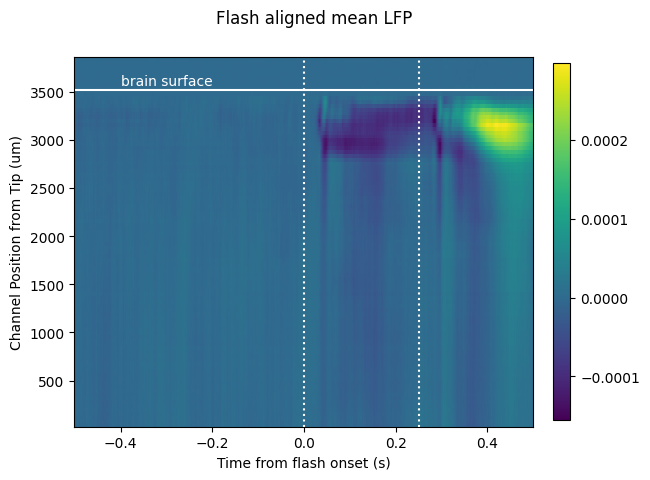

In [94]:
fig, ax = plt.subplots()
fig.suptitle('Flash aligned mean LFP')
im = ax.pcolor(aligned_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_lfp.mean(dim='presentation_id').data)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Time from flash onset (s)')
_ = plt.ylabel('Channel Position from Tip (um)')

ax.axvline(0, c='w', ls='dotted')
ax.axvline(0.25, c='w', ls='dotted')
ax.axhline(first_channel_in_brain_position, c='w')
ax.text(-0.4, first_channel_in_brain_position+50, 'brain surface', c='w')

In [95]:
def calculate_csd2d(lfp_data, delta=1):
    """Current source density (CSD) estimation

    Parameters
    ----------
    lfp_data : array, shape (n_channels, n_times)
        LFP data.
    delta : int
        Spacing between channels (um), scales the CSD.

    Returns
    -------
    csd2d : array, shape (n_channels, n_times)
        The 2nd derivative current source density estimate (csd2d)

    Notes
    -----
    The three-point finite-difference approximation of the
    second spatial derivative for computing 1-dimensional CSD
    with border electrode interpolation
    csd[electrode] = -(LFP[electrode - 1] - 2*LFP[electrode] +
                       LFP[electrode + 1]) / spacing ** 2
    """
    csd2d = -np.diff(lfp_data, n=2, axis=0) / delta ** 2
    bottom_border = csd2d[-1, :] * 2 - csd2d[-2, :]
    top_border = csd2d[0, :] * 2 - csd2d[1, :]
    csd2d = np.concatenate((top_border[None, ...], csd2d,
                            bottom_border[None, ...]), axis=0)
    return csd2d

def plot_laminar_csd(times, data, contact_labels, ax=None, colorbar=True,
                     vmin=None, vmax=None, sink='b', interpolation='spline',
                     show=True):
    """Plot laminar current source density (CSD) estimation from LFP array.

    Parameters
    ----------
    times : Numpy array, shape (n_times,)
        Sampling times (in ms).
    data : array-like, shape (n_channels, n_times)
        CSD data, channels x time.
    ax : instance of matplotlib figure | None
        The matplotlib axis.
    colorbar : bool
        If True (default), adjust figure to include colorbar.
    contact_labels : list
        Labels associated with the contacts to plot. Passed as-is to
        :func:`~matplotlib.axes.Axes.set_yticklabels`.
    vmin: float, optional
        lower bound of the color axis.
        Will be set automatically of None.
    vmax: float, optional
        upper bound of the color axis.
        Will be set automatically of None.
    sink : str
        If set to 'blue' or 'b', plots sinks in blue and sources in red,
        if set to 'red' or 'r', sinks plotted in red and sources blue.
    interpolation : str | None
        If 'spline', will smoothen the CSD using spline method,
        if None, no smoothing will be applied.

    show : bool
        If True, show the plot.

    Returns
    -------
    fig : instance of matplotlib Figure
        The matplotlib figure handle.
    """
    import matplotlib.pyplot as plt
    from scipy.interpolate import RectBivariateSpline

    if ax is None:
        _, ax = plt.subplots(1, 1, constrained_layout=True)

    if sink[0].lower() == 'b':
        cmap = "jet"
    elif sink[0].lower() == 'r':
        cmap = "jet_r"
    elif sink[0].lower() != 'b' or sink[0].lower() != 'r':
        raise RuntimeError('Please use sink = "b" or sink = "r".'
                           ' Only colormap "jet" is supported for CSD.')

    if interpolation == 'spline':
        # create interpolation function
        interp_data = RectBivariateSpline(times, contact_labels, data.T)
        # increase number of contacts
        new_depths = np.linspace(contact_labels[0], contact_labels[-1],
                                 1000)
        # interpolate
        data = interp_data(times, new_depths).T
    elif interpolation is None:
        data = data
        new_depths = contact_labels

    # if vmin and vmax are both None, set colormap such that green = zero
    if vmin is None and vmax is None:
        vmin = -np.max(np.abs(data))
        vmax = np.max(np.abs(data))

    im = ax.pcolormesh(times, new_depths, data,
                       cmap=cmap, shading='auto', vmin=vmin, vmax=vmax)
    ax.set_xlabel('time (s)')
    ax.set_ylabel('electrode depth')
    if colorbar:
        color_axis = ax.inset_axes([1.05, 0, 0.02, 1], transform=ax.transAxes)
        plt.colorbar(im, ax=ax, cax=color_axis).set_label(r'$CSD (uV/um^{2})$')

    plt.tight_layout()

    return ax.get_figure()

In [96]:
mean_lfp = aligned_lfp.mean(dim='presentation_id').data
times = aligned_lfp.time_from_presentation_onset.values
csd = calculate_csd2d(mean_lfp)

/tmp/ipykernel_14891/1616169997.py:109: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


(-0.1, 0.4)

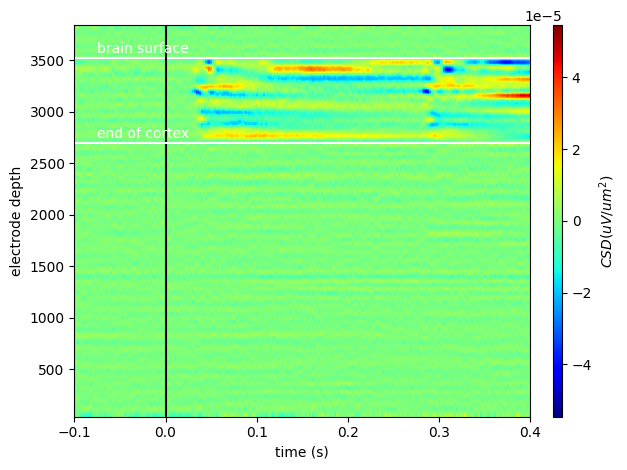

In [97]:
plot_laminar_csd(times, csd, lfp_chan_depths)
chans_in_v1 = chans[(chans['probe_id']==1064735073)&(chans['structure_acronym'].str.contains('VISp'))]
last_cortex_channel_position = chans_in_v1['probe_vertical_position'].min()

plt.axhline(first_channel_in_brain_position, c='w')
plt.axvline(0.0, c='k')
plt.text(-0.075, first_channel_in_brain_position+50, 'brain surface', c='w')
plt.axhline(last_cortex_channel_position, c='w')
plt.text(-0.075, last_cortex_channel_position+50, 'end of cortex', c='w')
plt.xlim(-0.1, 0.4)

### calculate spectral events

In [199]:
samp_freq = 500
bounds = np.arange(0, 100_000)

# set parameters
freqs = list(range(1, 60 + 1))   # fequency values (Hz) over which to calculate TFR
times = np.arange(len(bounds)) / samp_freq  # seconds
event_band = [4,10]  # beta band (Hz)
thresh_FOM = 3.0  # fac

In [200]:
spont_lfp.shape

(96, 144496)

In [217]:
chan_idx = 74

tfrs = se.tfr(spont_lfp[chan_idx, bounds], freqs, samp_freq)
spec_events = se.find_events(tfr=tfrs, times=times, freqs=freqs,
                             event_band=event_band, threshold_FOM=thresh_FOM)

event_df_list = list()
for event_idx, event_dict in enumerate(spec_events[0]):
    event_dict['event_idx'] = event_idx
    event_df_list.append(event_dict)
event_df = pd.DataFrame(event_df_list)
event_df = event_df[event_df['Peak Power'] > 1e-9]
print(len(event_df))

44


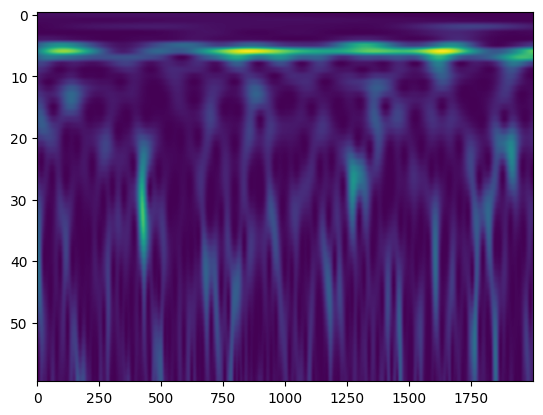

In [202]:
plt.imshow(tfrs[0,:,:2000], aspect='auto')

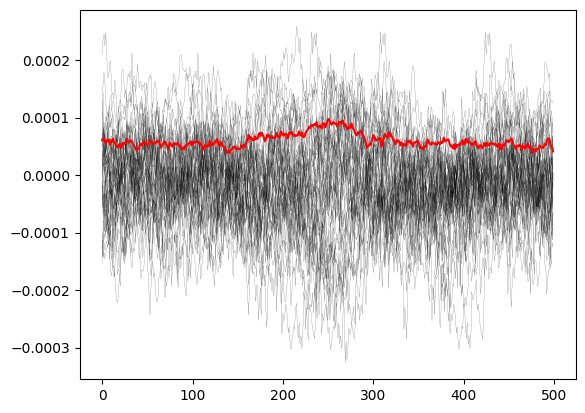

In [219]:
peak_times = event_df['Peak Time'].values + spont_lfp.time.values[0]
aligned_alpha_lfp = align_lfp(spont_lfp, np.arange(-0.5, 0.5, 1/500), peak_times)
_ = plt.plot(aligned_alpha_lfp[76,:100,:].T, color='k', linewidth=0.1)
_ = plt.plot(np.mean(np.abs(aligned_alpha_lfp[76,:,:].T), axis=1), color='r')

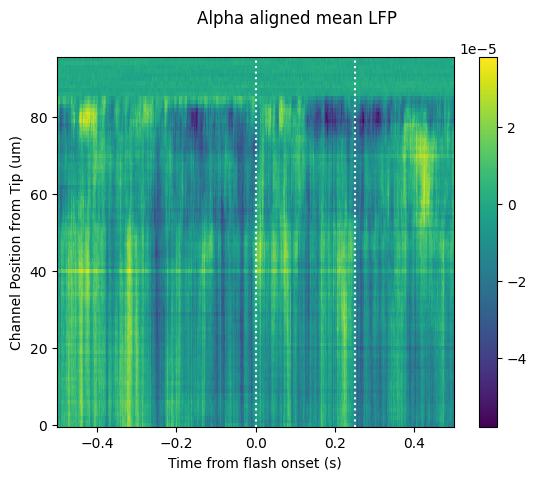

In [204]:
fig, ax = plt.subplots()
fig.suptitle('Alpha aligned mean LFP')
# _ = ax.pcolor(aligned_alpha_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_alpha_lfp.mean(dim='presentation_id').data)
im = ax.pcolor(aligned_alpha_lfp.time_from_presentation_onset.values, range(len(lfp_chan_depths)), aligned_alpha_lfp.mean(dim='presentation_id').data)

_ = plt.colorbar(im)
_ = plt.xlabel('Time from flash onset (s)')
_ = plt.ylabel('Channel Position from Tip (um)')

ax.axvline(0, c='w', ls='dotted')
ax.axvline(0.25, c='w', ls='dotted')
# ax.axhline(first_channel_in_brain_position, c='w')
# ax.text(-0.4, first_channel_in_brain_position+50, 'brain surface', c='w')


### Calculate event aligned CSDs

In [59]:
bounds = np.arange(0, 100_000)
N = 73
fs = 500
delay = 0.5 * (N-1) / fs
taps_alpha = scipy.signal.firwin(numtaps=73, cutoff=[1, 8], fs=fs, window='hamming', pass_zero=False)

chan_idx = 74
# chan_idx = 10
lfp_alpha = scipy.signal.lfilter(taps_alpha, 1.0, spont_lfp[bounds,:].T).T
# envelope_alpha = np.abs(scipy.signal.hilbert(lfp_alpha[:,chan_idx]))
# envelope_alpha = np.diff(np.abs(lfp_alpha[:,chan_idx]))

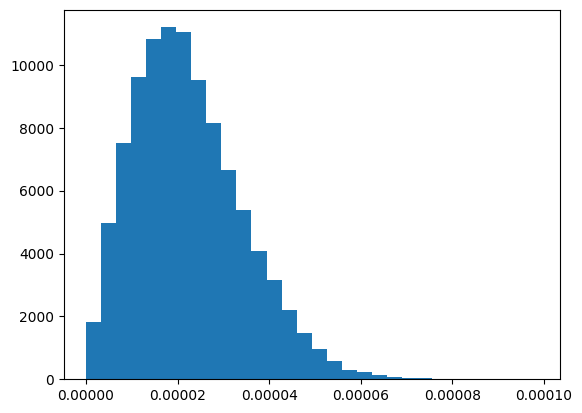

In [311]:
_ = plt.hist(envelope_alpha, bins=30)

In [79]:
# peaks, _ = find_peaks(envelope_alpha, height=0.00001)
peaks, _ = find_peaks(lfp_alpha[:,chan_idx], height=0.000001, distance=1000, prominence=0.00005)
print(len(peaks))
peak_times = lfp.time.values[peaks] + spont_lfp.time_from_presentation_onset.values[0]
# peak_times = np.random.choice(range(100_000), size=100)

72


In [80]:
# pick trials with low average running speed
aligned_alpha_lfp = align_lfp(lfp, np.arange(-0.5, 0.5, 1/500), peak_times)
print(aligned_alpha_lfp.shape)

# aligned_alpha_running = align_running(running_speed.set_index('timestamps').to_xarray(), np.arange(-0.5, 0.5, 1/60), peak_times)
# alpha_running_mean = np.mean(aligned_alpha_running, axis=1)
# running_mask = alpha_running_mean < 1
# aligned_alpha_lfp = aligned_alpha_lfp[:, running_mask ,:]
# print(aligned_alpha_lfp.shape)

(96, 72, 500)


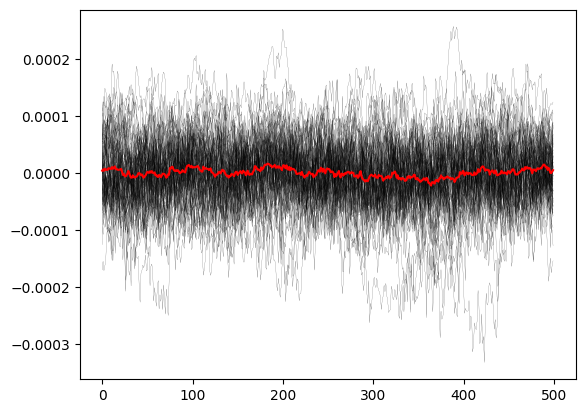

In [85]:
# _ = plt.plot(lfp_alpha[76,:].T, color='k', linewidth=0.1)
_ = plt.plot(aligned_alpha_lfp[76,:,:].T, color='k', linewidth=0.1)
_ = plt.plot(np.mean(aligned_alpha_lfp[76,:,:].T, axis=1), color='r')

In [ ]:
fig, ax = plt.subplots()
fig.suptitle('Alpha aligned mean LFP')
# _ = ax.pcolor(aligned_alpha_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_alpha_lfp.mean(dim='presentation_id').data)
im = ax.pcolor(aligned_alpha_lfp.time_from_presentation_onset.values, range(len(lfp_chan_depths)), aligned_alpha_lfp.mean(dim='presentation_id').data)

_ = plt.colorbar(im)
_ = plt.xlabel('Time from flash onset (s)')
_ = plt.ylabel('Channel Position from Tip (um)')

ax.axvline(0, c='w', ls='dotted')
ax.axvline(0.25, c='w', ls='dotted')
# ax.axhline(first_channel_in_brain_position, c='w')
# ax.text(-0.4, first_channel_in_brain_position+50, 'brain surface', c='w')


In [ ]:
mean_alpha_lfp = aligned_alpha_lfp.mean(dim='presentation_id').data
times_alpha = aligned_alpha_lfp.time_from_presentation_onset.values
csd_alpha = calculate_csd2d(mean_alpha_lfp)

/tmp/ipykernel_85/1616169997.py:109: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(-0.075, 2750, 'end of cortex')

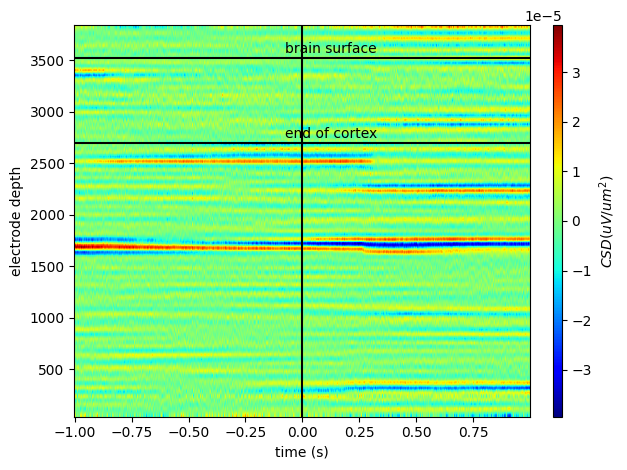

In [243]:
plot_laminar_csd(times_alpha, csd_alpha, lfp_chan_depths)
chans_in_v1 = chans[(chans['probe_id']==1064735073)&(chans['structure_acronym'].str.contains('VISp'))]
last_cortex_channel_position = chans_in_v1['probe_vertical_position'].min()

plt.axhline(first_channel_in_brain_position, c='k')
plt.axvline(0.0, c='k')
plt.text(-0.075, first_channel_in_brain_position+50, 'brain surface', c='k')
plt.axhline(last_cortex_channel_position, c='k')
plt.text(-0.075, last_cortex_channel_position+50, 'end of cortex', c='k')
# plt.xlim(-0.1, 0.2)

/tmp/ipykernel_85/1616169997.py:109: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


(2000.0, 3600.0)

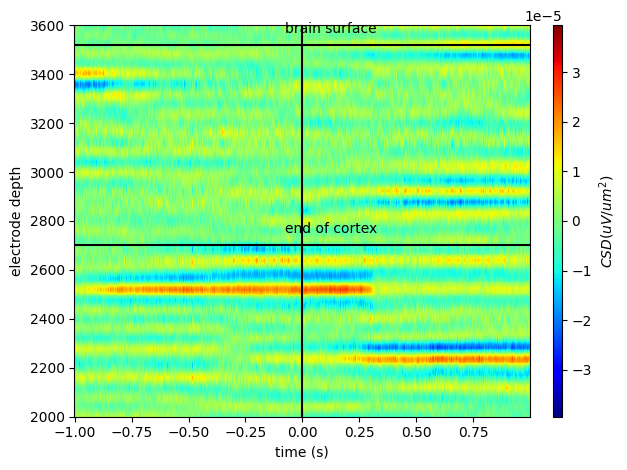

In [244]:
plot_laminar_csd(times_alpha, csd_alpha, lfp_chan_depths)
chans_in_v1 = chans[(chans['probe_id']==1064735073)&(chans['structure_acronym'].str.contains('VISp'))]
last_cortex_channel_position = chans_in_v1['probe_vertical_position'].min()

plt.axhline(first_channel_in_brain_position, c='k')
plt.axvline(0.0, c='k')
plt.text(-0.075, first_channel_in_brain_position+50, 'brain surface', c='k')
plt.axhline(last_cortex_channel_position, c='k')
plt.text(-0.075, last_cortex_channel_position+50, 'end of cortex', c='k')
plt.ylim(2000, 3600)